In [69]:
import pandas as pd

df = pd.read_csv("/home/kush/machine_learning/ClassificationThyroidDiseases_ByUltrasoundImage/data/total_data.csv")
df.head()

,name,default_mean,default_std,default_min,default_max,default_median,default_skewness,default_kurtosis,default_1_quantile,default_2_quantile,...,figure_mean,figure_area,figure_max,figure_min,figure_std,figure_perimeter,figure_skewness,figure_median,figure_kurtosis,target
0,69_2,88.001217,38.134743,13,255,83.0,0.933868,1.409521,35.0,43.0,...,72.027110,2287,183,18,23.668996,180.076865,1.692969,68.0,4.578270,0
1,380_1,82.335703,41.009582,7,255,79.0,0.650147,0.397588,24.0,29.0,...,71.692199,57235,249,9,32.342588,913.065723,0.349716,72.0,0.060053,0
2,158_2,97.597160,43.821470,7,255,90.0,0.895270,0.647084,40.0,48.0,...,75.991837,6248,216,29,24.794651,299.780540,1.878780,71.0,5.121252,0
3,66_1,78.756686,31.397057,9,245,75.0,0.704825,0.662901,35.0,41.0,...,63.814262,12523,173,11,22.628529,557.980631,0.597191,61.0,0.136921,0
4,69_3,93.166859,37.735053,12,255,92.0,0.394197,0.062712,35.0,43.0,...,82.739580,2903,189,19,23.651310,210.073542,0.327607,82.0,0.276633,0


In [70]:
df.shape

(301, 480)

In [71]:
df["default_mean"].mean()

74.91006733822202

In [72]:
df["figure_mean"].mean()

76.10363503962836

In [73]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["target", "name"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=52, stratify=y)

In [8]:
y_train.value_counts()

target
1    135
0     75
Name: count, dtype: int64

In [9]:
y_test.value_counts()

target
1    58
0    33
Name: count, dtype: int64

Преобразование PCA

In [74]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


pca = PCA(30)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

Подбор гиперпараметров  PCA

In [75]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [100]:
models = {
    "SVC": SVC(),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "Xgboost": xgb.XGBClassifier(),
}

scoring = {"recall": "recall", "f1": "f1", "precision": "precision"}

params_grid = {
    "SVC": {
        "C": [0.1, 1, 3, 5, 7, 10, 100],
        "kernel": ["linear", "poly", "rbf", "sigmoid"],
        "gamma": [1, 0.1, 0.01, 0.001],
    },
    "DecisionTree": {
        "criterion": ["gini", "entropy"],
        "max_depth": [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, None],
    },
    "RandomForest": {
        "n_estimators": [50, 100, 150, 200, 250, 300],
        "max_depth": [None, 3, 5, 7, 10, 15, 20, 25, 30],
    },
    "Xgboost": {
        "n_estimators": [50, 100, 150, 200, 250, 300],
        "max_depth": [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 25, 30, None],
        "learning_rate": [0.01, 0.1],
    },
    "KNN": {
        "n_neighbors": [2, 3, 4, 5, 6, 7, 8, 9, 10],
        "metric": ["euclidean", "manhattan", "cosine"],
    },
}

for name, model in models.items():

    grid_search = GridSearchCV(estimator=model, param_grid=params_grid[name], cv=5, scoring="accuracy", n_jobs=-1)

    grid_search.fit(X_train_pca, y_train)

    print(name)
    print("Лучшие параметры:", grid_search.best_params_)
    print("Лучшее значение метрики:", grid_search.best_score_)
    print("-" * 50)

SVC
Лучшие параметры: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Лучшее значение метрики: 0.6761904761904762
--------------------------------------------------
DecisionTree
Лучшие параметры: {'criterion': 'entropy', 'max_depth': 3}
Лучшее значение метрики: 0.6523809523809524
--------------------------------------------------
RandomForest
Лучшие параметры: {'max_depth': 15, 'n_estimators': 50}
Лучшее значение метрики: 0.7190476190476189
--------------------------------------------------
KNN
Лучшие параметры: {'metric': 'manhattan', 'n_neighbors': 10}
Лучшее значение метрики: 0.6428571428571428
--------------------------------------------------
Xgboost
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150}
Лучшее значение метрики: 0.680952380952381
--------------------------------------------------


Предсказание PCA

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

training_models = {
    "SVM": SVC(C=1, gamma=0.01, kernel="rbf"),
    "KNN": KNeighborsClassifier(metric="manhattan", n_neighbors=10),
    "RandomForest": RandomForestClassifier(max_depth=15, n_estimators=50),
    "Xgboost": xgb.XGBClassifier(learning_rate=0.1, max_depth=9, n_estimators=150),
}

all_preds = {}


for name, model in training_models.items():
    model.fit(X_train_pca, y_train)

    y_pred = model.predict(X_test_pca)
    all_preds[name] = y_pred

    print(name)
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

SVM
              precision    recall  f1-score   support

           0       0.50      0.09      0.15        33
           1       0.65      0.95      0.77        58

    accuracy                           0.64        91
   macro avg       0.57      0.52      0.46        91
weighted avg       0.59      0.64      0.55        91

[[ 3 30]
 [ 3 55]]
KNN
              precision    recall  f1-score   support

           0       0.41      0.21      0.28        33
           1       0.65      0.83      0.73        58

    accuracy                           0.60        91
   macro avg       0.53      0.52      0.50        91
weighted avg       0.56      0.60      0.57        91

[[ 7 26]
 [10 48]]
RandomForest
              precision    recall  f1-score   support

           0       0.80      0.24      0.37        33
           1       0.69      0.97      0.81        58

    accuracy                           0.70        91
   macro avg       0.75      0.60      0.59        91
weighted avg   

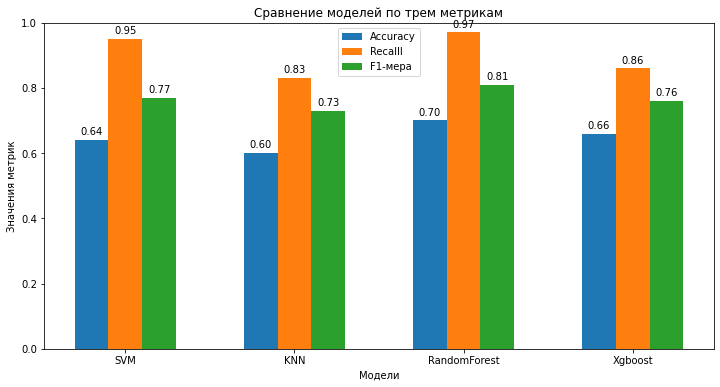

In [158]:
import matplotlib.pyplot as plt
import numpy as np

models = ["SVM", "KNN", "RandomForest", "Xgboost"]
accuracy = [0.64, 0.6, 0.7, 0.66]
metric_2 = [0.95, 0.83, 0.97, 0.86]
metric_3 = [0.77, 0.73, 0.81, 0.76]

x = np.arange(len(models)) * 0.5

width = 0.1

fig, ax = plt.subplots(figsize=(12, 6))

bar1 = ax.bar(x - width, accuracy, width, label="Accuracy", color="#1f77b4")
bar2 = ax.bar(x, metric_2, width, label="Recalll", color="#ff7f0e")
bar3 = ax.bar(x + width, metric_3, width, label="F1-мера", color="#2ca02c")

ax.set_xlabel("Модели")
ax.set_ylabel("Значения метрик")
ax.set_title("Сравнение моделей по трем метрикам")
ax.set_xticks(x)
ax.set_xticklabels(models)

ax.set_ylim(0, 1)

ax.legend()


def add_labels(bars):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f"{yval:.2f}", ha="center", va="bottom")


add_labels(bar1)
add_labels(bar2)
add_labels(bar3)

plt.savefig("metrics_result.png")
plt.show()

In [91]:
all_preds["target"] = y_test
all_preds_df = pd.DataFrame(all_preds)
all_preds_df

,SVM,KNN,RandomForest,Xgboost,target
174,1,1,1,1,1
242,1,1,1,1,1
268,1,0,1,1,1
11,1,1,1,1,0
63,1,1,1,1,0
...,...,...,...,...,...
271,1,1,1,1,1
153,1,1,0,0,1
118,1,1,1,1,1
83,1,1,1,1,0


In [92]:
all_preds_df["predict"] = all_preds_df.apply(
    lambda row: 1 if (row[["SVM", "KNN", "RandomForest", "Xgboost"]] == row["target"]).any() else 0, axis=1
)

In [93]:
print(classification_report(all_preds_df["target"], all_preds_df["predict"]))
print(confusion_matrix(all_preds_df["target"], all_preds_df["predict"]))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80        33
           1       0.84      1.00      0.91        58

    accuracy                           0.88        91
   macro avg       0.92      0.83      0.86        91
weighted avg       0.90      0.88      0.87        91

[[22 11]
 [ 0 58]]


Преобразование PCA с использованием SMOTE

In [12]:
from collections import Counter

from imblearn.over_sampling import SMOTE

print("Распределение классов до SMOTE:", Counter(y_train))

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Распределение классов после SMOTE:", Counter(y_train_resampled))

Распределение классов до SMOTE: Counter({1: 135, 0: 75})
Распределение классов после SMOTE: Counter({1: 135, 0: 135})


In [13]:
scaler = StandardScaler()
scaler.fit(X_train_resampled)

X_train_resample_scaled = scaler.transform(X_train_resampled)
X_test_resample_scaled = scaler.transform(X_test)

X_train_resample_pca = pca.fit_transform(X_train_resample_scaled)
X_test_resample_pca = pca.transform(X_test_resample_scaled)

Подбор гиперпараметров PCA SMOTE

In [253]:
for name, model in models.items():

    grid_search = GridSearchCV(estimator=model, param_grid=params_grid[name], cv=5, scoring="f1", n_jobs=-1)

    grid_search.fit(X_train_resample_pca, y_train_resampled)

    print(name)
    print("Лучшие параметры:", grid_search.best_params_)
    print("Лучшее значение метрики:", grid_search.best_score_)
    print("-" * 50)

SVC
Лучшие параметры: {'C': 3, 'gamma': 0.1, 'kernel': 'rbf'}
Лучшее значение метрики: 0.8149230520758483
--------------------------------------------------
DecisionTree
Лучшие параметры: {'criterion': 'entropy', 'max_depth': 6}
Лучшее значение метрики: 0.6830484377401577
--------------------------------------------------
RandomForest
Лучшие параметры: {'max_depth': 10, 'n_estimators': 150}
Лучшее значение метрики: 0.8146209000762777
--------------------------------------------------
KNN
Лучшие параметры: {'metric': 'manhattan', 'n_neighbors': 5}
Лучшее значение метрики: 0.655816323379551
--------------------------------------------------
Xgboost
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 250}
Лучшее значение метрики: 0.7612811579776866
--------------------------------------------------


Предсказание PCA SMOTE

In [41]:
training_models = {
    "SVM": SVC(C=3, gamma=0.1, kernel="rbf"),
    "KNN": KNeighborsClassifier(metric="manhattan", n_neighbors=5),
    "RandomForest": RandomForestClassifier(max_depth=10, n_estimators=150),
    "DecisionTree": DecisionTreeClassifier(criterion="entropy", max_depth=6),
    "Xgboost": xgb.XGBClassifier(learning_rate=0.1, max_depth=7, n_estimators=250),
}


for name, model in training_models.items():
    model.fit(X_train_resample_pca, y_train_resampled)

    y_pred = model.predict(X_test_resample_pca)

    print(name)
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

SVM
              precision    recall  f1-score   support

           0       0.67      0.06      0.11        33
           1       0.65      0.98      0.78        58

    accuracy                           0.65        91
   macro avg       0.66      0.52      0.45        91
weighted avg       0.65      0.65      0.54        91

[[ 2 31]
 [ 1 57]]
KNN
              precision    recall  f1-score   support

           0       0.39      0.45      0.42        33
           1       0.66      0.60      0.63        58

    accuracy                           0.55        91
   macro avg       0.53      0.53      0.53        91
weighted avg       0.56      0.55      0.56        91

[[15 18]
 [23 35]]
RandomForest
              precision    recall  f1-score   support

           0       0.58      0.42      0.49        33
           1       0.72      0.83      0.77        58

    accuracy                           0.68        91
   macro avg       0.65      0.63      0.63        91
weighted avg   

Ансамблевая модель (голосование)

In [14]:
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

xgboost = xgb.XGBClassifier(learning_rate=0.1, max_depth=7, n_estimators=200)
forest = RandomForestClassifier(max_depth=10, n_estimators=300)
svm = SVC(C=1, gamma=0.1, kernel="rbf")

xgboost.fit(X_train, y_train)
forest.fit(X_train, y_train)
svm.fit(X_train, y_train)

# Создание ансамблевой модели
voting_clf = VotingClassifier(
    estimators=[("xgb", xgboost), ("random_forest", forest), ("svm", svm)], voting="hard"
)  # 'soft' для вероятностей, 'hard' для меток

voting_clf.fit(X_train_pca, y_train)

# Оценка качества
y_pred = voting_clf.predict(X_test_pca)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.21      0.31        33
           1       0.67      0.91      0.77        58

    accuracy                           0.66        91
   macro avg       0.63      0.56      0.54        91
weighted avg       0.64      0.66      0.61        91

[[ 7 26]
 [ 5 53]]


Преобразование признаков (Top 30)

In [14]:
features = df.drop(columns=["target"])
target = df["target"]

correlations = features.corrwith(target)

sorted_features = correlations.abs().sort_values(ascending=False)

top_30_features = sorted_features.head(30)

print("Топ-30 признаков по модулю корреляции с таргетом:")
print(top_30_features)

Топ-30 признаков по модулю корреляции с таргетом:
sobel_LL_std                       0.198516
sobel_std                          0.195455
sobel_0_glcm_correlation           0.194013
default_0_glcm_correlation         0.191342
equalized_std_phase                0.190975
default_std_phase                  0.182481
equalized_HH_std                   0.180327
equalized_HH_energy                0.178518
equalized_0_glcm_contrast          0.178282
equalized_0_glcm_dissimilarity     0.177871
equalized_0_glcm_homogeneity       0.177260
equalized_0_glcm_correlation       0.176862
default_LL_std                     0.175768
blur_std                           0.175368
equalized_HL_std                   0.174091
default_std                        0.173322
equalized_19_quantile              0.172194
blur_LL_std                        0.172020
equalized_0_glcm_energy            0.171789
equalized_0_glcm_asm               0.171283
figure_LL_energy                   0.170867
equalized_45_glcm_dissimil

/home/kush/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/kush/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [15]:
df = df[list(top_30_features.index) + ["target"]]

In [16]:
X = df.drop(columns=["target"])
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=52, stratify=y)

In [17]:
df.head()

,sobel_LL_std,sobel_std,sobel_0_glcm_correlation,default_0_glcm_correlation,equalized_std_phase,default_std_phase,equalized_HH_std,equalized_HH_energy,equalized_0_glcm_contrast,equalized_0_glcm_dissimilarity,...,equalized_45_glcm_dissimilarity,equalized_45_glcm_contrast,equalized_90_glcm_contrast,equalized_45_glcm_correlation,equalized_HL_energy,equalized_90_glcm_dissimilarity,equalized_90_glcm_correlation,default_90_glcm_correlation,default_45_glcm_correlation,target
0,41.821286,21.444097,0.905555,0.962791,1.804362,1.805627,9.224044,2257686.5,1.256920,0.719524,...,1.536968,4.536531,4.211932,0.892087,4.741510e+06,1.468285,0.899821,0.899410,0.893213,0
1,40.068296,20.858099,0.901862,0.964926,1.799156,1.801973,10.061835,2701098.0,1.277187,0.748127,...,1.683002,5.409241,5.415770,0.871359,4.148892e+06,1.682128,0.871310,0.865377,0.863855,0
2,47.279994,24.205311,0.920091,0.965993,1.826664,1.823796,10.218312,2770626.0,1.244428,0.728124,...,1.520171,4.456205,4.264989,0.893882,4.228860e+06,1.479097,0.898419,0.892787,0.887184,0
3,32.773926,17.089805,0.842552,0.932966,1.828150,1.830395,15.884388,6731850.0,2.306843,1.070709,...,2.202786,8.690530,8.462635,0.792813,9.229914e+06,2.169033,0.798426,0.789492,0.784337,0
4,39.033946,20.226403,0.885118,0.964529,1.817522,1.819177,9.272376,2293865.5,1.151499,0.714571,...,1.659145,5.169875,4.768266,0.877388,5.228721e+06,1.586226,0.887021,0.879450,0.869462,0


In [18]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Подбор гиперпараметров Top 30

In [19]:
models = {
    "SVC": SVC(),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(),
    "KNN": KNeighborsClassifier(),
    "Xgboost": xgb.XGBClassifier(),
}

scoring = {"recall": "recall", "f1": "f1", "precision": "precision"}

params_grid = {
    "SVC": {
        "C": [0.1, 1, 3, 5, 7, 10, 100],
        "kernel": ["linear", "poly", "rbf", "sigmoid"],
        "gamma": [1, 0.1, 0.01, 0.001],
    },
    "DecisionTree": {
        "criterion": ["gini", "entropy"],
        "max_depth": [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, None],
    },
    "RandomForest": {
        "n_estimators": [50, 100, 150, 200, 250, 300],
        "max_depth": [None, 3, 5, 7, 10, 15, 20, 25, 30],
    },
    "Xgboost": {
        "n_estimators": [50, 100, 150, 200, 250, 300],
        "max_depth": [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 25, 30, None],
        "learning_rate": [0.01, 0.1],
    },
    "KNN": {
        "n_neighbors": [2, 3, 4, 5, 6, 7, 8, 9, 10],
        "metric": ["euclidean", "manhattan", "cosine"],
    },
}

In [31]:
for name, model in models.items():

    grid_search = GridSearchCV(estimator=model, param_grid=params_grid[name], cv=5, scoring="accuracy", n_jobs=-1)

    grid_search.fit(X_train_scaled, y_train)

    print(name)
    print("Лучшие параметры:", grid_search.best_params_)
    print("Лучшее значение метрики:", grid_search.best_score_)
    print("-" * 50)

SVC
Лучшие параметры: {'C': 100, 'gamma': 1, 'kernel': 'linear'}
Лучшее значение метрики: 0.6904761904761905
--------------------------------------------------
DecisionTree
Лучшие параметры: {'criterion': 'gini', 'max_depth': None}
Лучшее значение метрики: 0.6190476190476191
--------------------------------------------------
RandomForest
Лучшие параметры: {'max_depth': 10, 'n_estimators': 100}
Лучшее значение метрики: 0.7
--------------------------------------------------
KNN
Лучшие параметры: {'metric': 'euclidean', 'n_neighbors': 5}
Лучшее значение метрики: 0.7095238095238094
--------------------------------------------------
Xgboost
Лучшие параметры: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 150}
Лучшее значение метрики: 0.6761904761904762
--------------------------------------------------


Предсказание Top 30

In [23]:
training_models = {
    "SVM": SVC(C=100, gamma=1, kernel="linear"),
    "KNN": KNeighborsClassifier(metric="euclidean", n_neighbors=5),
    "RandomForest": RandomForestClassifier(max_depth=10, n_estimators=100),
    "DecisionTree": DecisionTreeClassifier(criterion="gini", max_depth=None),
    "Xgboost": xgb.XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=150),
}


for name, model in training_models.items():
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)

    print(name)
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

SVM
              precision    recall  f1-score   support

           0       0.46      0.39      0.43        33
           1       0.68      0.74      0.71        58

    accuracy                           0.62        91
   macro avg       0.57      0.57      0.57        91
weighted avg       0.60      0.62      0.61        91

[[13 20]
 [15 43]]
KNN
              precision    recall  f1-score   support

           0       0.47      0.27      0.35        33
           1       0.67      0.83      0.74        58

    accuracy                           0.63        91
   macro avg       0.57      0.55      0.54        91
weighted avg       0.60      0.63      0.60        91

[[ 9 24]
 [10 48]]
RandomForest
              precision    recall  f1-score   support

           0       0.53      0.24      0.33        33
           1       0.67      0.88      0.76        58

    accuracy                           0.65        91
   macro avg       0.60      0.56      0.55        91
weighted avg   

Преобразование признаков Top 30 SMOTE

In [24]:
print("Распределение классов до SMOTE:", Counter(y_train))

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Распределение классов после SMOTE:", Counter(y_train_resampled))

Распределение классов до SMOTE: Counter({1: 135, 0: 75})
Распределение классов после SMOTE: Counter({1: 135, 0: 135})


In [25]:
scaler = StandardScaler()
scaler.fit(X_train_resampled)

X_train_resample_scaled = scaler.transform(X_train_resampled)
X_test_resample_scaled = scaler.transform(X_test)

Подбор гиперпараметров Top 30 SMOTE

In [27]:
for name, model in models.items():

    grid_search = GridSearchCV(estimator=model, param_grid=params_grid[name], cv=5, scoring="f1", n_jobs=-1)

    grid_search.fit(X_train_resample_scaled, y_train_resampled)

    print(name)
    print("Лучшие параметры:", grid_search.best_params_)
    print("Лучшее значение метрики:", grid_search.best_score_)
    print("-" * 50)

SVC
Лучшие параметры: {'C': 3, 'gamma': 1, 'kernel': 'rbf'}
Лучшее значение метрики: 0.8135675381263617
--------------------------------------------------
DecisionTree
Лучшие параметры: {'criterion': 'entropy', 'max_depth': None}
Лучшее значение метрики: 0.681924663200113
--------------------------------------------------
RandomForest
Лучшие параметры: {'max_depth': 25, 'n_estimators': 200}
Лучшее значение метрики: 0.7284816031675827
--------------------------------------------------
KNN
Лучшие параметры: {'metric': 'cosine', 'n_neighbors': 3}
Лучшее значение метрики: 0.693611859838275
--------------------------------------------------
Xgboost
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Лучшее значение метрики: 0.7078689258196647
--------------------------------------------------


Предсказание Top 30 SMOTE

In [29]:
models = {
    "SVM": SVC(C=3, gamma=1, kernel="rbf"),
    "KNN": KNeighborsClassifier(metric="cosine", n_neighbors=3),
    "RandomForest": RandomForestClassifier(max_depth=25, n_estimators=200),
    "DecisionTree": DecisionTreeClassifier(criterion="entropy", max_depth=None),
    "Xgboost": xgb.XGBClassifier(learning_rate=0.1, max_depth=3, n_estimators=100),
}


for name, model in models.items():
    model.fit(X_train_resample_scaled, y_train_resampled)

    y_pred = model.predict(X_test_resample_scaled)

    print(name)
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

SVM
              precision    recall  f1-score   support

           0       0.50      0.06      0.11        33
           1       0.64      0.97      0.77        58

    accuracy                           0.64        91
   macro avg       0.57      0.51      0.44        91
weighted avg       0.59      0.64      0.53        91

[[ 2 31]
 [ 2 56]]
KNN
              precision    recall  f1-score   support

           0       0.56      0.45      0.50        33
           1       0.72      0.79      0.75        58

    accuracy                           0.67        91
   macro avg       0.64      0.62      0.63        91
weighted avg       0.66      0.67      0.66        91

[[15 18]
 [12 46]]
RandomForest
              precision    recall  f1-score   support

           0       0.44      0.36      0.40        33
           1       0.67      0.74      0.70        58

    accuracy                           0.60        91
   macro avg       0.56      0.55      0.55        91
weighted avg   